大部分图像处理任务都需要先进行二值化操作，阈值的选取很关键，Otsu阈值法会自动计算阈值。

Otsu阈值法（日本人大津展之提出的，也可称大津算法）非常适用于双峰图片

## 什么是双峰图片？
双峰图片就是指图片的灰度直方图上有两个峰值，直方图就是每个值（0~255）的像素点个数统计，后面会详细介绍。
![](http://blog.codec.wang/cv2_bimodal_image_two_peaks.jpg)
Otsu算法假设这副图片由前景色和背景色组成，通过统计学方法（最大类间方差）选取一个阈值，将前景和背景尽可能分开，我们先来看下代码，然后详细说明下算法原理。

## 代码示例
下面这段代码对比了使用固定阈值和Otsu阈值后的不同结果：

另外，对含噪点的图像，先进行滤波操作效果会更好。

In [6]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('noisy.jpg', 0)

ret1, th1 = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)

ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

blur = cv2.GaussianBlur(img, (5, 5), 0)
ret3, th3 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(img)

[[52 49 49 ... 50 57 62]
 [63 55 62 ... 47 38 39]
 [46 56 37 ... 61 54 63]
 ...
 [43 58 41 ... 46 50 41]
 [43 45 60 ... 54 52 55]
 [66 34 55 ... 36 52 48]]


下面我们用Matplotlib把原图、直方图和阈值图都显示出来：

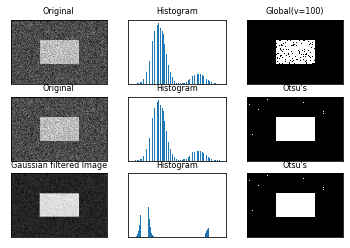

In [9]:
images = [img, 0, th1, img, 0, th2, blur, 0, th3]
titles = ['Original', 'Histogram', 'Global(v=100)',
          'Original', 'Histogram', "Otsu's",
          'Gaussian filtered Image', 'Histogram', "Otsu's"]

for i in range(3):
    # 绘制原图
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i * 3], 'gray')
    plt.title(titles[i * 3], fontsize=8)
    plt.xticks([]), plt.yticks([])

    # 绘制直方图plt.hist，ravel函数将数组降成一维
    plt.subplot(3, 3, i * 3 + 2)
    plt.hist(images[i * 3].ravel(), 256)
    plt.title(titles[i * 3 + 1], fontsize=8)
    plt.xticks([]), plt.yticks([])

    # 绘制阈值图
    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(images[i * 3 + 2], 'gray')
    plt.title(titles[i * 3 + 2], fontsize=8)
    plt.xticks([]), plt.yticks([])
plt.show()

可以看到，Otsu阈值明显优于固定阈值，省去了不断尝试阈值判断效果好坏的过程。其中，绘制直方图时，使用了numpy中的ravel()函数，它会将原矩阵压缩成一维数组，便于画直方图。

## Otsu算法详解
Otsu阈值法将整幅图分为前景（目标）和背景，以下是一些符号规定：
- T：分割阈值
- N0：前景像素点数
- N1：背景像素点数
- ω0：前景的像素点数占整幅图像的比例
- ω1：背景的像素点数占整幅图像的比例
- μ0：前景的平均像素值
- μ1：背景的平均像素值
- μ：整幅图的平均像素值
- rows×cols：图像的行数和列数

结合下图会更容易理解一些，有一副大小为4×4的图片，假设阈值T为1，那么：
![](http://blog.codec.wang/cv2_otsu_theory_sample.jpg)
其实很好理解，N0+N1就是总的像素点个数，也就是行数乘列数：
N0+N1=rows×cols

ω0和ω1是前/背景所占的比例，也就是：
ω0=N0rows×cols

ω1=N1rows×cols

ω0+ω1=1                                 (1)

整幅图的平均像素值就是：

μ=ω0×μ0+ω1×μ1                       (2)

此时，我们定义一个前景μ0与背景μ1的方差g：

g=ω0(μ0−μ)^2+ω1(μ1−μ)^2               (3)

将前述的1/2/3公式整合在一起，便是：

g=ω0ω1(μ0−μ1)^2

g就是前景与背景两类之间的方差，这个值越大，说明前景和背景的差别也就越大，效果越好。Otsu算法便是遍历阈值T，使得g最大，所以又称为最大类间方差法。基本上双峰图片的阈值T在两峰之间的谷底。
